<a href="https://colab.research.google.com/github/rchartra/Data-Science-in-Oceanography/blob/main/PO_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Oceanography (PO)

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/PO/SST_Winds.png?raw=1" width=1000/>

This tutorial is part of our Physical Oceanography day. It demonstrates how to do basic analysis and visualization of gridded oceanic and atmospheric data. We will use the so-called reanalysis data, a modeled estimate of how the ocean and atmosphere have evolved over the past several decades. This data has been downloaded using Copernicus API, a giant data database for Earth system observations and modeling. See the readme.txt and the download_era.py script for instructions on downloading the data -- it is very simple to do once you see an example.

### Estimated tutorial time: 2 hours

## Tutorial goals
- Python Skills
    - Work with xarray package
    - Make different plots and videos
    - Calculate climatology and anomalies from it
    - Calculate global mean quantities from lat/lon data using area weights
    - Smooth noisy time series to identify long-term trends
    - Calculate conditional averages
- PO knowledge
    - Learn about the variability of ocean temperatures on seasonal and interannual timescale
    - Identify if global warming trends can be seen in surface ocean temperature
    - See what El Nino and La Nina events look like and how the world responds to it
    
## Data

- ERA5 is the fifth generation ECMWF reanalysis for the global climate and weather for the past 4 to 7 decades. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. We will use just a few of its two-dimensional variables, including the sea surface temperature (SST), atmospheric precipitation, surface pressure and winds, as well as the 2 meter air temperature.  The ERA5 data was pre-downloaded using the Copernicus API: https://cds.climate.copernicus.eu/api-how-to. The download_era.py script gets this data:  https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means-preliminary-back-extension?tab=form

- Once you download the  data, there will be an .nc file that is loded and analysed in ENSO.ipynb (the data has already been downloaded so no need to re-download it unless you need extra variables). To speed up the analysis, we coarsened the dataset from 1/4 degree to a 1 degree grid and saved it as __ERA5_Coarse.nc__




    
## Reading

Johnson, G. C., & Lyman, J. M. (2020). Warming trends increasingly dominate global ocean. Nature Climate Change, 10(8), 757-761. https://www.nature.com/articles/s41558-020-0822-0

McPhaden, Michael J., Stephen E. Zebiak, and Michael H. Glantz. "ENSO as an integrating concept in earth science." Science 314, no. 5806 (2006): 1740-1745. https://doi.org/10.1126/science.1132588    

# Let's start!

## Using google drive to load files

First, create a shortcut to the shared google drive folder and put it into your MyDrive folder. This way it wi# Run this cell to mount your google drive to use in colab
from google.colab import drive
drive.mount('/content/drive')ll be visible to google colab when you mount your google drive.

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/PO/google_drive_shortcut.png?raw=1" width=400/>

In [ ]:
# Run this cell to mount your google drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the packages
Start by importing everything you need: this sometimes requires the installation of packages that are not yet in your environment. To install a new package, create a new cell in the notebook, type __!pip install packagename__ and execute. Tip: use __Shift+Enter__ as a shortcut for executing a cell.

In Jupyter notebooks, the exclamation mark ! executes commands from the underlying operating system. So you can use your standard Linux commands, like __dir__ or __du -sh *__.

In [ ]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np                 #for general calculations.
import matplotlib.pyplot as plt    #making plots.
import xarray as xr                #loading and working with data in an optimal way.

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

#this command allows interactive plots in noteboks
%matplotlib inline

__xarray__ opens the file and loads its format/variables but doesn't load the whole data until it is directly necessary for calculations or plotting. Let's learn how to use it!

In [ ]:
#Specify the data file to load
ERA5_Coarse='/content/drive/MyDrive/Datasets2023/ERA5/ERA5_Coarse.nc'  #loading from google drive
#ERA5_Coarse="C:/Users/User/Downloads/ERA5_Coarse.nc"    #loading from local path

era = xr.open_dataset(ERA5_Coarse)  #xarray can open different format data, netcdf is one of them
era                                 #this simply prints what's in the dataset

<xarray.Dataset>
Dimensions:    (time: 756, latitude: 180, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 0.375 1.375 2.375 3.375 ... 357.4 358.4 359.4
  * latitude   (latitude) float32 89.62 88.62 87.62 ... -87.38 -88.38 -89.38
  * time       (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2021-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    t2m_F      (time, latitude, longitude) float32 ...

### Creating a new xarray variable

When presenting to a general audience in US, it might be better to plot temperatures in Fahrenheit (or Celcius) instead of Kelvin.

Let's create a variable that is the temperature in Fahrenheit and add it to our existing xarray variables. As you saw above, xarray variables have __attributes__ that specify useful information about the variables, like their longer description, units, and sourse of data. Adding attributes to all variables is a good practice.

In [ ]:
era['t2m_F']=(era['t2m']-273.15)*1.8 + 32             #Use the formula to get from C to F.

era['t2m_F'].attrs['long_name']='2m temperature'      #Add some attributes as name:value pairs.
era['t2m_F'].attrs['units']='Fahrenheit'
era['t2m_F'].attrs['formula']='(K-273.15) x 1.8 + 32'

era['t2m_F']                                           #see the new variable

### Making a quick plot
xarray includes plotting commands that use matplotlib in the background; this is useful to quickly view the data without having to specify the axis labels, colorbars, titles -- all of it is done for you!

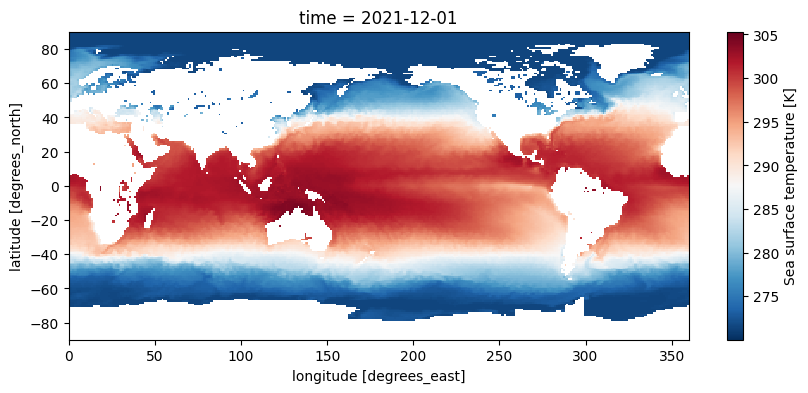

In [ ]:
plt.figure(figsize=(10,4))                  #Specify figure size in inches
era.isel(time=-1)['sst'].plot(cmap='RdBu_r') #Plot using in-built xarray tools; isel() selects based on specified indices
plt.savefig('sst.png')                      #Save the figure as a png file

### Making a video

Create a plotting function that takes a single argument (frame number) and makes a corresponding figure. The video is then a sequence of frames that can be encoded (compressed) into a conventional mp4 video format, which can also be embedded into this notebook.

In [ ]:
sst_video=era['sst'].sel(time=slice("2020", "2022"))-273.15 #in Celcius now

def animation_func(i):
    fig.clear()
    ax = plt.axes(projection=ccrs.PlateCarree())                  #specifying the projection such that coasline data could be added
    sst_video.isel(time=i).plot(cmap='RdBu_r',vmin=0, vmax=30)    #plotting the data
    ax.add_feature(cfeature.COASTLINE)                            #adding the coastline over the plotted data
    ax.add_feature(cfeature.BORDERS)                              #adding the borders

    plt.axis('off')

fig = plt.figure(figsize=(10,4))
animation = FuncAnimation(fig, animation_func,
                          frames = len(sst_video.time))

animation.save('sst.mp4')
plt.close()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


In [ ]:
Video('sst.mp4') #display the video in the notebook

In [ ]:
#if you're using google colab, the video will likely not display. One workaround is to encode the binary data into characters. Base64 is one of these types of encodings.
from base64 import b64encode

def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
show_video('sst.mp4') #display/stream the encoded video in colab

## In-class exercise \#1: Make a video of precipitation
Follow the example above and make a video of total precipitation, which is the __'tp'__ variable in our __era__ xarray.

First, make a single timeframe figure you are happy with; then, make a video out of all frames using  __animation__

Search online for "matplotlib colormaps" to find a colormap of your liking to represent precipitation and specify it when plotting

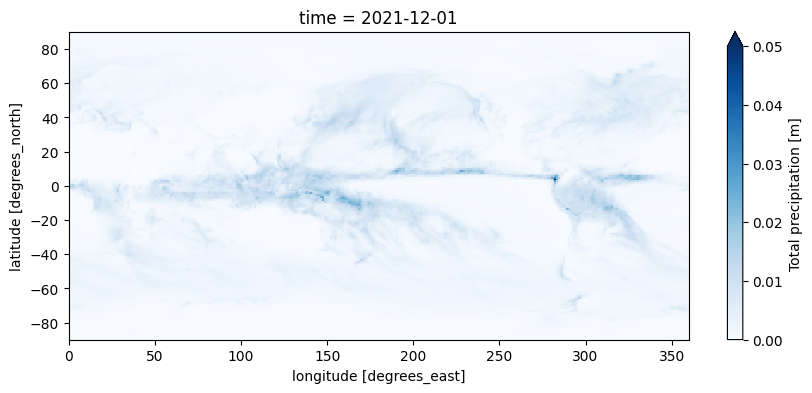

In [ ]:
#Your code goes here
plt.figure(figsize=(10,4))                  #Specify figure size in inches
print(min())
era.isel(time=-1)['tp'].plot(cmap='Blues', vmin=0, vmax=0.05) #Plot using in-built xarray tools; isel() selects based on specified indices
plt.savefig('tp.png')

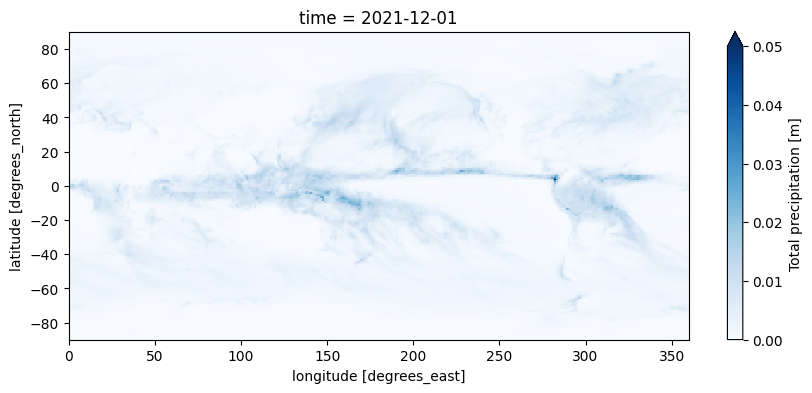

In [ ]:
#Your code goes here
plt.figure(figsize=(10,4))                  #Specify figure size in inches
era.isel(time=-1)['tp'].plot(cmap='Blues', vmin=0, vmax=0.05) #Plot using in-built xarray tools; isel() selects based on specified indices
plt.savefig('tp.png')

tp_video=era['tp'].sel(time=slice("2020", "2022"))


def animation_func(i):
    fig.clear()
    ax = plt.axes(projection=ccrs.PlateCarree())                  #specifying the projection such that coasline data could be added
    tp_video.isel(time=i).plot(cmap='Blues', vmin=0, vmax=0.05)    #plotting the data

    plt.axis('off')

fig = plt.figure(figsize=(10,4))
animation = FuncAnimation(fig, animation_func,
                          frames = len(tp_video.time))

animation.save('tp.mp4')
plt.close()


def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video('tp.mp4')


## Slicing the xarray

Learn how to select ranges of variables:
- The .sel()  selects variables by their ranges: era.sel(latitude > 30)
- The .isel() selects based on the index of variables: era.isel(latidude = 604)

### Data nearest to a point

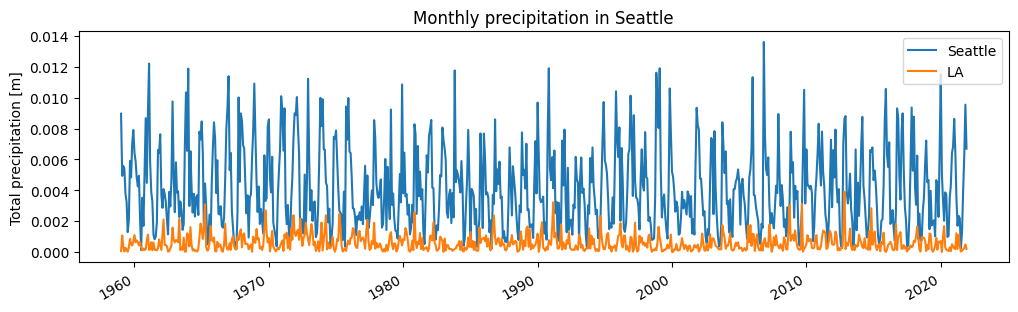

In [ ]:
Lat_Seattle=47.6062      #Define the coordinates or a point of interests
Lon_Seattle=360-122.3321

Lat_LA=34.0522;
Lon_LA= -118.2437


era_Seattle=era.sel(longitude=Lon_Seattle,
                    latitude=Lat_Seattle,
                    method="nearest")     #Get the data from a point nearest to the desired lat/lon location

era_LA=era.sel(longitude=Lon_LA,
                    latitude=Lat_LA,
                    method="nearest")     #Get the data from a point nearest to the desired lat/lon location


plt.figure(figsize=(12, 3))
era_Seattle['tp'].plot(label='Seattle')                  #xarray figured out that you only have timeseries and made an appropriate plot
era_LA['tp'].plot(label='LA')                  #xarray figured out that you only have timeseries and made an appropriate plot
plt.xlabel(''); plt.title('Monthly precipitation in Seattle');
plt.legend()


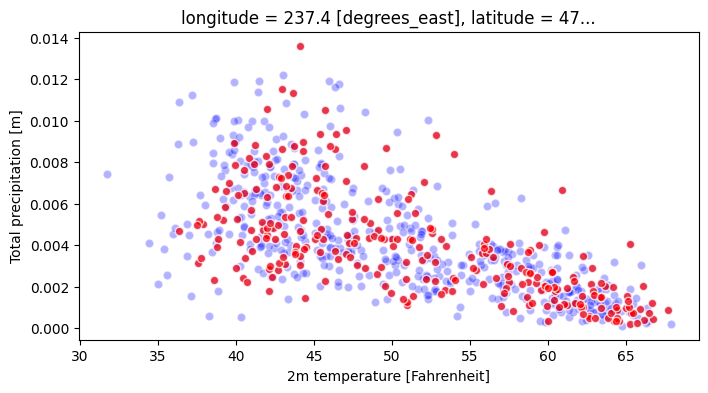

In [ ]:
#Choosing different time slices

era_Seattle_recent=era_Seattle.sel(time=slice("2000-01", "2022-01")) # slice() creates a range of all values between the specified bounds

plt.figure(figsize=(8,4))
era_Seattle.plot.scatter(x='t2m_F',y='tp',color='blue',alpha=0.3) # scatter plot of surface temperature and precipitation in Seattle;
era_Seattle_recent.plot.scatter(x='t2m_F',y='tp',color='red',alpha=0.7);  # highlight points from a chosen time range
#the parameter alpha has a range [0,1] and makes points transparent


As you can see from the plot above, higher precipitation is generally correlated with lower temperatures. Note that we are dealing with monthly-mean data, and the temperature variability is dominated by seasonal cycles. This implies that precipitation in Seattle is higher in winter than in summer.

I bet it isn't raining right now as you going over the tutorial with us: am I wrong?

### Nearest data to an array of points

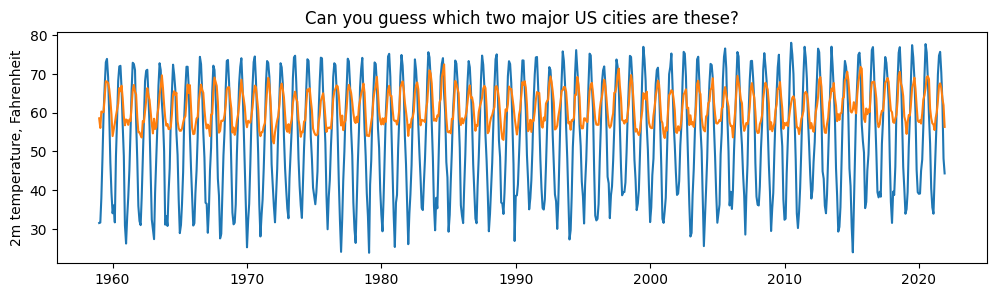

In [ ]:
point_lats=np.array([40.7128, 34.0522 ])            #define the lat/lon coordinates of the points
point_lons=360-np.array([74.0060, 118.2437])

point_lats=xr.DataArray(point_lats, dims="points")  #create xarrays from those coordinates with a new dimension called for example "points"
point_lons=xr.DataArray(point_lons, dims="points")

point_sst=era['t2m_F'].sel(latitude=point_lats, longitude=point_lons,
                           method='nearest',tolerance=0.5)


plt.figure(figsize=(12, 3))
plt.plot(point_sst.time,point_sst[:,0])
plt.plot(point_sst.time,point_sst[:,1])
plt.ylabel(point_sst.long_name + ', ' + point_sst.units)
plt.title('Can you guess which two major US cities are these?');

## Calculating weighted means

Each pixel of the data represents an area of different sizes. Hence the global mean value can be significantly different from a pixel average. Make sure you do weighted averages! Below is an example of calculating a global mean temperature and its long-term trends

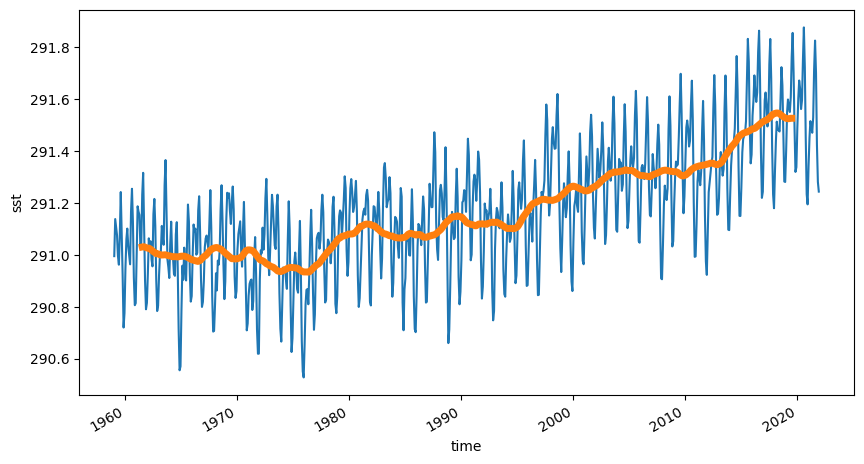

In [ ]:
sst=era['sst']

weights = np.cos(np.deg2rad(era.latitude)); weights.name = "weights" # area of the cell scales as dlat*dlon*cos(lat) and we can use it to compute weighted averages; note, dlat=dlon for this dataset.

SST_global_mean = sst.weighted(weights).mean(dim=['latitude','longitude']) # this IS area-weighted mean

#The mean SST has long-term positive trend -- aka Global Warming! Let's calculate a running mean to more clearly see this trend

SST_global_mean_runningMean=SST_global_mean.rolling(time=12*5,center=True).mean() # global mean smoothed over many months

plt.figure(figsize=(10,5))
SST_global_mean.plot(label="SST" )
SST_global_mean_runningMean.plot(label="SST rolling mean", linewidth=5 );

## Calculating climatology and anomalies
Since there is a very strong repeating seasonal cycle on Earth, it is often convenient to focus on deviations from this seasonal cycle, which are called anomalies.  

Monthly climatology refers to variables that are averaged after being grouped by months. Anomalies are deviations from climatology.

Let's see what temperature anomalies look like in the ocean and if they give a qualitatively different picture of the ocean variability.

In [ ]:
era_clim=era.groupby("time.month").mean('time') # creating monthly mean climatology

## In-class exercise \#2: calculating and plotting anomalies

The strongest El Nino event on record was on December 1997. Calculate and plot the temperature of the ocean as an anomaly from its climatology at the time of the El Nino event.

Instructions:
 - use xarray's .groupby("time.month") option to group the original dataset by months first before subtracting from it the climatology; xarray figures out how to properly broadcast the arrays of different dimensions
 - name the anomaly array as __era_a__ and select the time of the El Nino event before plotting a map.
 - add to the plot the box of the so-called Nino3.4 index: an area of the tropical Pacific ocean where SST is strongly responding to ENSO events. The Nino34 box is bounded by latitude (-5,5) degrees and by longitude (190,240) degrees. You can use the plt.plot to add it, by specifying the coordinates of the box. Make sure to check that the box is in the right place!

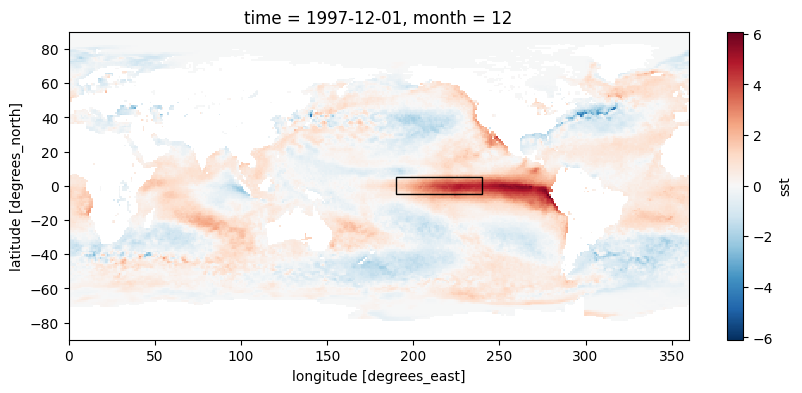

In [ ]:
#Your code for calculating the anomaly goes here
import matplotlib.patches as patches

era_a = era.groupby("time.month")-era_clim      # xarray figures out broadcasting of arrays to take the difference between era(t) and era(month)
plt.figure(figsize=(10,4))
ax = plt.axes()
era_a.sel(time="1997-12")['sst'].plot()

ax.add_patch(patches.Rectangle((190, -5), 50, 10, linewidth=1, edgecolor='k', facecolor='none'))


In [ ]:
#Plot the temperature anomaly for a strong El Nino event

## El Niño -- Southern Oscillation (ENSO)

El Niño is the warm phase of the El Niño–Southern Oscillation and is associated with a band of warm ocean water that develops in the central and east-central equatorial Pacific, including the area off the Pacific coast of South America. https://en.wikipedia.org/wiki/El_Ni%C3%B1o


NOAA considers El Niño conditions to be present in the ocean when the Oceanic Nino Index (ONI) in that area, known as the Niño-3.4 region, is +0.5 or higher, meaning surface waters in the east-central tropical Pacific are 0.5 degrees Celsius (0.9 degrees Fahrenheit) or more warmer than average. https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index

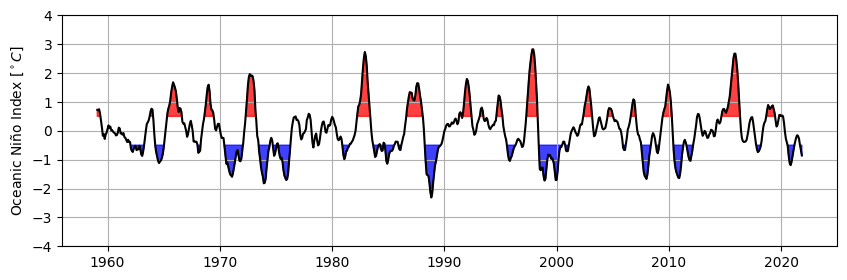

In [ ]:
NINO34 = era_a['sst'].sel(latitude=slice(5,-5),
                  longitude=slice(190,240)).weighted(weights).mean(dim=['latitude','longitude'])

ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months

plt.figure(figsize=(10,3))
ax=plt.gca()
plt.plot(ONI.time, ONI,'k')
ax.fill_between(ONI.time.data, 0.5, ONI, ONI> 0.5, color='red', alpha=.75)
ax.fill_between(ONI.time.data, -0.5, ONI, ONI< -0.5, color='blue',  alpha=.75)
plt.ylim((-4,4))
plt.grid(visible=True)
plt.ylabel('Oceanic Niño Index [$^\circ C$]');

### Global mean temperature and ENSO

To have a clearer view of how the global mean ocean temperature varies on interannual timescales, let's remove the long-term trends and explore their relation to ONI.


In [ ]:
SSTa_global_mean = era_a['sst'].weighted(weights).mean(dim=['latitude','longitude']) # this IS area-weighted mean
SSTa_global_mean_runningMean=SSTa_global_mean.rolling(time=12*5,center=True).mean() # global anomaly mean smoothed over many months

SSTa_global_mean_Detrended=(SSTa_global_mean-SSTa_global_mean_runningMean)

plt.figure(figsize=(10,6))

ax=plt.subplot(2,1,1)
ONI.plot(ax=ax, xlim=('1955','2025'))
plt.ylabel('Oceanic Niño Index [$^\circ C$]');plt.ylim((-4,4))

ax=plt.subplot(2,1,2)
SSTa_global_mean_Detrended.plot(ax=ax, xlim=('1955','2025'))
plt.ylabel("Detrended global mean SST anomaly")
plt.ylim((-0.4,0.4));

### Calculating a correlation coefficient

In [ ]:
#Now we can clearly see the strong correlation between the Global Ocean Temperature and ENSO defined using NINO3 index
x=ONI.data; y=SSTa_global_mean_Detrended.data
x=x[~np.isnan(y)];  y=y[~np.isnan(y)] # remove nan that polyfit can't deal with

correlation = np.corrcoef(x, y)[0,1] #calculate a correlation coefficient between ONI and global mean temperature anomaly

print('correlation = ', correlation)

correlation =  0.6243330598714717


## In-class exercise \#3: conditional averages

Calculate mean temperature and precipitation during El Nino and La Nina events. What patterns stand out to you?

- Compute conditional averages
- Make a figure with multiple maps of specified projections



In [ ]:
#Your code goes here

TPa_global_mean = era_a['tp'].weighted(weights).mean(dim=['latitude','longitude']) # this IS area-weighted mean
TPa_global_mean_runningMean=TPa_global_mean.rolling(time=12*5,center=True).mean()

TPa_global_mean_Detrended = TPa_global_mean - TPa_global_mean_runningMean

NINO34 = era_a['sst'].sel(latitude=slice(5,-5),
                  longitude=slice(190,240)).weighted(weights).mean(dim=['latitude','longitude'])

ONI= NINO34.rolling(time=3,center=True).mean() #rolling mean over 3 months

SST_nino = SSTa_global_mean_Detrended[[i for i in range(len(ONI)) if ONI[i] > 0.5]].mean()
TP_nino = TPa_global_mean_Detrended[[i for i in range(len(ONI)) if ONI[i] > 0.5]].mean()

SST_nina = SSTa_global_mean_Detrended[[i for i in range(len(ONI)) if ONI[i] < -0.5]].mean()
TP_nina = TPa_global_mean_Detrended[[i for i in range(len(ONI)) if ONI[i] < -0.5]].mean()


In [ ]:
TP_nina

<xarray.DataArray 'tp' ()>
array(-8.314525e-06, dtype=float32)

### Have a look at the "PlottingMaps" tutorial for examples of plots with different projections

# Take-home exercise: Seattle temperature and precipitation during El Nino and La Nina
Figure out what happens in Seattle during ENSO events. Is it raining more or less? Is it hotter or colder? El Nino is defined as the ONI index being higher than 0.5 and La Nina lower than -0.5.

- use our previously defined variable era_Seattle
- use the groupby("time.month") and mean('time') operations to calculate the climatology
- define the anomaly as the difference between the groupped by time.month data and the climatology
- calculate conditional averages of the anomaly fields for precipitation and temperature for La Nina (ONI<-0.5) and El Nino (ONI>0.5)
- make some nice figures

In [ ]:
#your code goes here